In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl

In [29]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [30]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup


{'02_l': 0,
 '04_fist_moved': 1,
 '09_c': 2,
 '10_down': 3,
 '06_index': 4,
 '08_palm_moved': 5,
 '07_ok': 6,
 '05_thumb': 7,
 '01_palm': 8,
 '03_fist': 9}

In [31]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

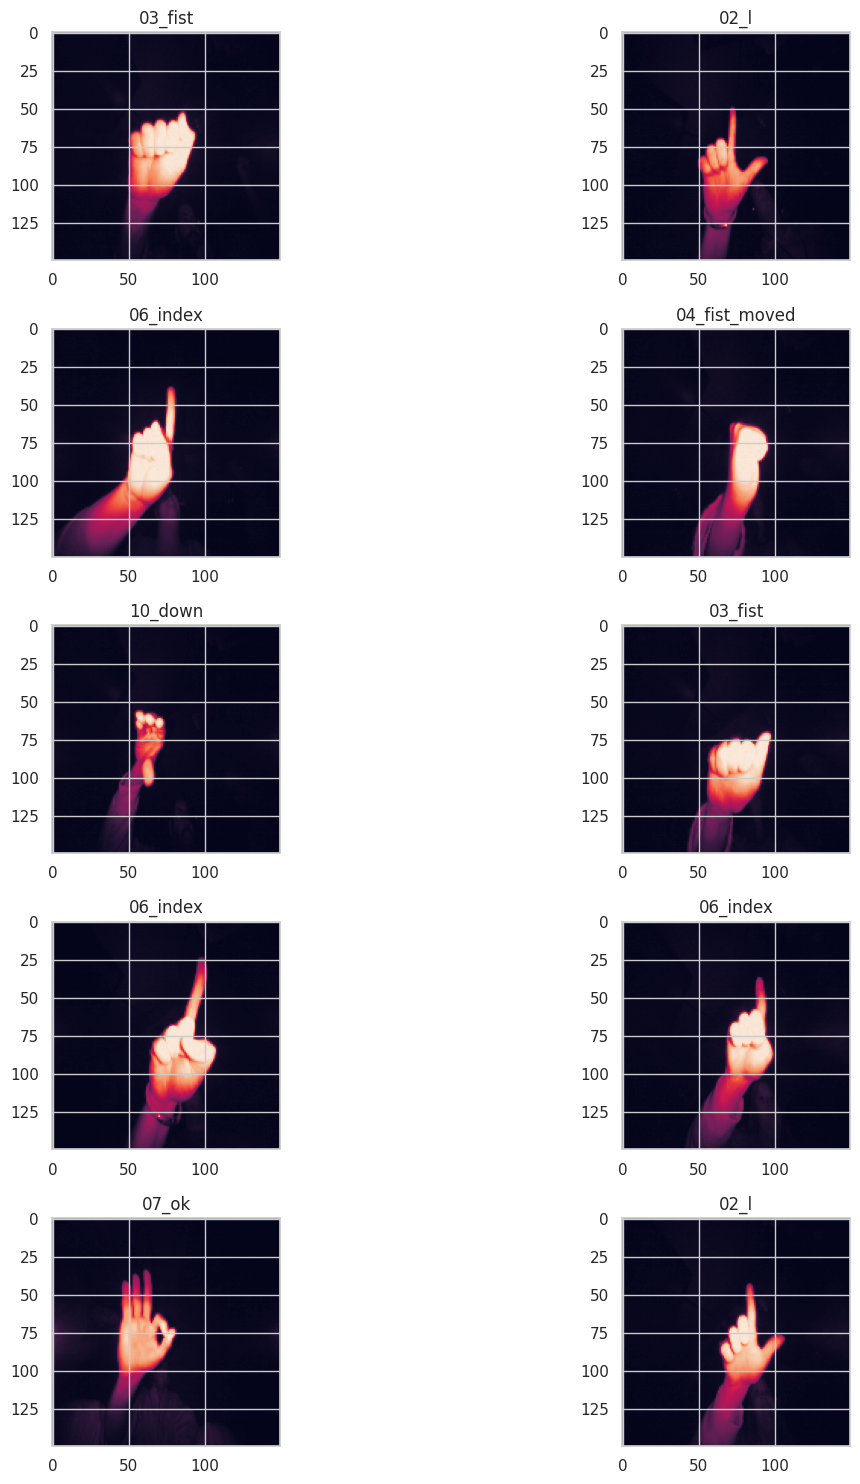

In [32]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [33]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [38]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

In [35]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [36]:
batch_size=128
epochs=10

In [41]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]


In [42]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 18, 96)       

In [ ]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8902
Epoch 1: val_loss improved from inf to 0.00601, saving model to ./base.model
118/118 [==============================] - 397s 3s/step - loss: 0.3205 - accuracy: 0.8902 - val_loss: 0.0060 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9930
Epoch 2: val_loss improved from 0.00601 to 0.00418, saving model to ./base.model
118/118 [==============================] - 388s 3s/step - loss: 0.0239 - accuracy: 0.9930 - val_loss: 0.0042 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 3: val_loss improved from 0.00418 to 0.00049, saving model to ./base.model
118/118 [==============================] - 441s 4s/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 4.9422e-04 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 4/10
118/118 [==============

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()